# SpringBoard 7.2:

<a id='top'></a>
## 2017 Impacts of Violence in Nepal are Highly Correlated with Population and Elections

The Nepal Monitor Project (NepalMonitor.org) comprehensively maps human rights and violence data across Nepal using the vast majority of national news sources. The embedded Peace Monitoring Project sends local sources in from 20+ districts to have all incidents of violence systematically mapped, with the goal of improving understanding of violence in Nepal to better respond to it and promote peace. This project started half way though 2016, making 2017 the first complete year Nepal Monitor can claim to have a comprehensive record of all violence appearing in Nepali Media.

In this initial exploration, I set out to answer some simple questions, with an eye toward evaluating the data set's use for further analysis. If the data is collected systematically and thoroughly, the answers to these questions should be positive.

<a href='#Question-1'>Question 1:</a> Are the impacts of violence in the data correlated with specific events?

<a href='#Question-2'>Question 2:</a> Are they correlated with population and/or with each other?

<a href='#Question-3'>Question 3:</a> Are there significant differences in trends between provinces that can be shown?

<a href='#Conclusions'>Skip to Conclusions</a>

### Data Preparation


The Nepal Monitor data set contains more than a hundred different category tags, and categorizes the actors and inferred causes of violence in detail. It also counts the impacts of each violent incident. 

1. As impact data is already quantitative, it is the lowest hanging fruit for analysis.  The first step after cleaning the dataset was to separate out the impacts.

2. Next was to create a data frame to plot impacts by date.

3. Finally, was to create a data frame to plot impacts by district, and combine that with 2011 population statistics and province number. Federal provinces in Nepal were newly created in 2017 as a result of a post conflict process, and will only have numbers until each Federal unit decides on a name.



In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)



#Import Main Data Frame
cleanpath='Data/NM_2016_17clean.csv'
df = pd.read_csv(cleanpath)

#print(df.shape[0],'x',df.shape[1])
#df.columns

In [2]:
# convert 'INCIDENT DATE' column to date time objects (and limit to 2017)
df['INCIDENT DATE'] = pd.to_datetime(df['INCIDENT DATE'])
df.index  = df['INCIDENT DATE']
df = df['2017']

In [3]:
## Create a dataframe for plotting impacts
#Drop out irrelivant frames
impactsdroplist = ['Peace Monitoring - General Information','INCIDENT TITLE', 'LOCATION', 'INCIDENT NUMBER', 
       'DESCRIPTION',  'Development Region', 'Zone','SOURCE', 'SOURCE TYPE',
       'Municipality/VDC', 'Ward', 'District(New)', 'Municipality/VDC(New)',
       'Ward(New)',
       'Event Date - Peace Monitoring','LATITUDE', 'LONGITUDE','CATEGORY',
       'Duration - only applicable to non-violent forms', 'Number of Injuries',
       'Violent vs non-violent', 'One-sided vs two-sided', 'Number of Deaths',
       'Collective vs interpersonal', 'Forms and Causes',
       'Event form - primary', 'Event form - secondary', 'Weapon', 'Weapon 2',
       'Cause - primary', 'Cause - secondary', 'Crosscutting issues',
       'Actor 1 - Perpetrator', 'Actor 1 - Number of People',
       'Actor 1 - Perpetrator Type', 'Actor 1 Entity Name',
       'Actor 1 - Youth -25 years or below- involvement',
       'Actor 2 - Perpetrator 2 or Target', 'Actor 2 Numbers',
       'Target - if one-sided violence',
       'Perpetrator 2 - if two-sided violence', 'Actor 2 entity name',
       'Actor 2 - Youth -25 years or below- involvement', 'Impacts','Election-related specific cause secondary', 'Verification Feedback',
       'VERIFIED']
impactsdf = df.drop(impactsdroplist,axis=1)

#We will only sort by district, so incidents with a lower location acurracy should be dropped.
ss = 'LOCATION ACCURACY'
#imask = ss[(ss == 'Zone') or (ss == 'Country') or (ss == 'Development Region')]
impactsdf = impactsdf[impactsdf[ss] != 'Zone']
impactsdf = impactsdf[impactsdf[ss] != 'Country']
impactsdf = impactsdf[impactsdf[ss] != 'Development Region']

#impactsdf.head()

In [4]:
#Create a dataframe for plotting impacts by Date
#Stats were not logged until midway through 2016. Let's remove 2017

#impactsdf = impactsdf.sort_index()

#group and sum up df
#imdist = impactsdf.groupby(['District']).sum()

imdate = impactsdf.groupby(['INCIDENT DATE']).sum()

#drop out values where these stats were not being recorded
imdate.dropna(axis=0,inplace=True)

imdate = imdate.sort_index()



#imdate = imdate['2017']

#imdate.head()


/home/nhorning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'INCIDENT DATE' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [5]:
#Create Dateaframe for plotting impacts by district
imdist = impactsdf.groupby(['District']).sum()
#imdist.head()

In [6]:
#Combine disticts data frame with province and population data
pop_pd = pd.read_csv('Data/District_Province_Population')
pop_pd = pop_pd.set_index('District')
pop_pd = pop_pd.sort_index()
#pop_pd.head()

In [7]:
#Test if district names are correct - Prints out the districts that don't match. 
for num in range(75):
    test = imdist.index[num] == pop_pd.index[num]
    if test == False:
        print(pop_pd.index[num],imdist.index[num])

In [8]:
#Put the Province in the index and take a look. 
imdist_pop = pop_pd.join(imdist)
#imdist_pop = imdist_pop.sort_by('Province')
#imdist_pop = imdist_pop.set_index(['Province','District'])
#imdist_pop.head()

## Functions:
As I progressed some of the functions for creating graphs began to take up some space. I moved them here to avoid breaking up the narrative.

In [9]:


#Create time series plots
#Agrigate by week / month 
imweek = imdate.resample('W').sum()
immonth = imdate.resample('M').sum()

def dc(m,d):
    return dt.datetime(2017,m,d)
    
def adddates(Range,df,ann):
#Create background colors and annotations based on time spans
    dtdict = {}
    begin = dc(2,20)
    end = dc(5,1)
    dtdict['Local Registration'] = [begin,end,'blue',0.05]
    begin = dc(5,2)
    end = dc(5,21)
    dtdict['1st Local'] = [begin,end,'blue',0.1]
    begin = dc(6,18)
    end = dc(7,5)
    dtdict['2nd Local'] = [begin,end,'blue',0.1]
    begin = dc(9,6)
    end = dc(9,25)
    dtdict['3rd local'] = [begin,end,'blue',0.1]
    begin = dc(9,24)
    end = dc(12,14)
    dtdict['HoR / Provincial'] = [begin, end, 'blue',0.05]
    #if ann == True:
    ymin, ymax = plt.ylim()
    xoffset = 0        
    for span in dtdict:  
        begin = dtdict[span][0]
        end = dtdict[span][1]
        c = dtdict[span][2]
        a = dtdict[span][3]
        for spn in dtdict:
            thatdate = dtdict[spn][0]
            if begin.month == thatdate.month: #(abs(othertop - top) < 3) and
                    #print(begin.month)
                days = begin.day - thatdate.day
                if days < 20 and days > 0:
                    xoffset = days * 2
                    #print(span, days, xoffset)
                #print(ymax, top)
        plt.axvspan(begin, end, color=c, alpha=a*2)
        if ann == True:
            plt.annotate(span, xy=(begin, ymax), xytext=(xoffset,3), textcoords='offset points', fontsize='x-large',color=c, alpha=a+0.5)
            
#plot killed and injured
def plotimpact(Range,title,interval,df,ann):
    top = 0
    imps=df.columns.tolist()

    for impact in Range:    
        n=imps.index(impact)
        c=catpal[n]
        plt.plot(impact, data=df, c=c)
        #print(c)
    
    elstr = ''
    adddates(Range,df,ann)
    elstr = ' - Election Rounds Highlighted'
    #plt.xlabel('Month')
    #plt.ylabel(interval + 'ly Total')
    #plt.title(title + ' ' + interval + elstr)
    plt.yticks(fontsize='large')
    plt.legend(loc='best', fontsize='medium')
    sns.despine()
    #sns.palplot(pal)
    #plt.show()


def fullrun(interval, df, cats, ann):
    imps=df.columns
    
    if 'Killed' in cats:
        plotimpact(imps[0:3],'Total Killed by',interval,df,ann)
    if 'Injured' in cats:
        plotimpact(imps[3:5],'Total Injured by', interval,df,ann)
    if 'Rapes' in cats:
        plotimpact(imps[5:8],'Total Rapes by', interval,df,ann)
    if 'Abductions' in cats:
        plotimpact(imps[8:11],'Total Abductions by', interval,df,ann)
    if 'Physical' in cats: 
        plotimpact(imps[11:],'Physical Damage by', interval,df,ann)

#fullrun('Week', imweek)
#fullrun('Month', immonth)

In [10]:
#Normalize df by population 
def normalize(df,per,log):
    df_norm = df
    for district in range(0,df_norm.shape[0]):
        for column in range(1,df_norm.shape[1]):
            impact = df_norm.iloc[district, column]
            pop = df_norm['Population'][district]
            if log == True:
                df_norm.iloc[district, column] = impact/(math.log(pop,20))
            else:
                df_norm.iloc[district, column] = impact/(pop/per) # <- should create no. incidents per this no. population. 
    return df_norm

imdist_pop_no_prov = imdist_pop.drop('Province', axis=1)
imdist_normalized = normalize(imdist_pop_no_prov, 100000, False)

#imdist_normalized.head()


In [11]:
#Create jointplots of impacts v. population. 
import seaborn as sns


def plot2joints(y1,y2):

    #plot 2 jointplots 
    sns.set(font_scale=0.85)
    JG1 = sns.jointplot(x='Population', y=y1, data=imdist_pop, kind='reg', size=10)
    plt.close()
    JG2 = sns.jointplot(x='Population', y=y2, data=imdist_pop, kind='reg', size=10)
    plt.close()
    
    
    #subplots migration
    f = plt.figure()
    #fig.set_size_inches(16,8)
    for J in [JG1, JG2]:
        for A in J.fig.axes:
            f._axstack.add(f._make_key(A), A)
    
    
    #subplots size adjustment
    f.axes[0].set_position([0.1, 0.06, 0.4,  0.4])
    f.axes[1].set_position([0.1, 0.45, 0.4,  0.05])
    f.axes[2].set_position([0.5, 0.06, 0.05, 0.4])
    f.axes[3].set_position([0.65, 0.06, 0.4,  0.4])
    f.axes[4].set_position([0.65, 0.45, 0.4,  0.05])
    f.axes[5].set_position([1.05, 0.06, 0.08, 0.4])
    #f.axes.set_size_inches(16,8)
    f.suptitle(y1+'/'+y2+' v. Population per District', x=1,y=1.5, fontsize='xx-large')
    plt.show()


In [12]:
#heatmap function
import seaborn as sns 
def plotheat(df,title):
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(A3))
    
    #set title
    ax.set_title(title, fontsize='x-large')
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    #create a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True
    
    
    #create heatmap
    hm = sns.heatmap(corr, cmap=cmap, center=0, square=True, mask=mask, linewidth=0.5)
    #print(corr.head())
    
    plt.xticks(fontsize='medium')
    plt.yticks(fontsize='medium')
    #label with pearson values
    for row in range(0,corr.shape[0]):
        for column in range(0,corr.shape[1]):
            pvalue = round(corr.iloc[column][row],2)
            if mask[column][row]==True and row!=column:
                hm.text(column+0.5, row+0.6, pvalue, horizontalalignment='center', verticalalignment='center', size='small', color='purple')
    #plt.show()

In [13]:
#Box Plots overlayed with swarm plots., 
def boxswarm(df,impact,title):
    fig, ax = plt.subplots()
    ax.set_title("Distribution of " + title + " by Province - 2017")
    fig.set_size_inches(A4)
    sns.set_style('white')
    p1 = sns.swarmplot(x='Province', y=impact, data=df, size=10, palette=provpal) #, jitter=True)

#Annotate max/min for province
    for p in range(1,8):
        im_prov = df.loc[df['Province'] == p]
        xpos = p-0.94
        ypos = max(im_prov[impact])
        yoffset = +3
        text = im_prov.loc[im_prov[impact] == ypos].index[0]
        if len(text) > 10:
            yoffset +=10
        plt.annotate(text, xy=(xpos,ypos), xytext=(0,yoffset), textcoords='offset points', fontsize='small')
        ypos = min(im_prov[impact])
        yoffset = -10
        text = im_prov.loc[im_prov[impact] == ypos].index[0]
        if len(text) > 10:
            yoffset -=10
        plt.annotate(text, xy=(xpos,ypos), xytext=(0,yoffset), textcoords='offset points', fontsize='small')

    sns.boxplot(x='Province', y=impact, data=df, boxprops=dict(alpha=.6), palette=provpal)
    
    sns.despine()
    plt.show()

#boxswarm(imdist_pop,'Total Killed','Violent Deaths')

In [14]:
#check for overlap of annotations
def checkoverlap(xpos,ypos,poscopy,text):
   
    up = 0.0
    over = 0
    xoffset = len(text)*5000
    #yoffset = .6
    xoff = xpos + xoffset
    #ypos += yoffset
    #print(poslist)
    xbuff = xoffset*2
    ybuff = 1.1
    for x, y in poscopy:
        #print(x,y)
        xdist = x-xoff
        ydist = y-ypos
        if (xdist + xoffset) != 0:
            if (abs(xdist) < xbuff) and (abs(ydist) < ybuff):
                #return True
                #if ydist != 0:
                up +=  ydist - up
                #if xdist != 0:
                over +=  xdist - over
                #print('Overlap:',' x=',x,'y=',y,'xpos=',xpos,'ypos=',ypos,'\n','xdist=',xdist,'ydist=',ydist,'xbuff=',xbuff,'ybuff=',ybuff,'up=',up,'over=',over)
                #up += upoff
                #over += overoff
    return tuple([up,over])

In [15]:
#label districts
def label_districts(poslist,districts):
    done = False
    count = 0
    while done == False:
        done = True
        poscopy = poslist
        for dist in districts:
            lst = districts[dist]
            comp = tuple([lst[0], lst[1]])
            app = tuple([lst[2], lst[3]])
            if comp != app:
                #print(dist, app)
                poscopy.append(app)
        for text in districts:
            #print(text)
            lst = districts[text]
            #print(lst)
            xpos = lst[0]
            ypos = lst[1]
            xloc = lst[2]
            yloc = lst[3]
            disp = checkoverlap(xloc,yloc,poscopy,text)
            dispy = disp[0]
            dispx = disp[1]
            if (dispy != 0) or (dispx != 0):
                count += 1
                done = False
                #print('Moving',text,':',dispy,dispx)
                #print(poslist[-5:])
                if (yloc < 0) or (count > 50):
                    yloc = yloc + .5
                else:
                    yloc = yloc - dispy
                if xloc < 0:
                    xloc = xloc + 10000
                else:
                    xloc = xloc - dispx
                districts[text] = [xpos,ypos,xloc,yloc]
            
    for text in districts:       
        lst = districts[text]
        #print(text,lst)
        xpos = lst[0]
        ypos = lst[1]
        xloc = lst[2]
        yloc = lst[3]
        text = text+' ('+str(round(ypos/xpos*100000,2))+')'
        if (xpos == xloc) and (ypos == yloc):
            p3.text(xpos+10000, ypos, text, horizontalalignment='left', size='small', color='black')
        else:
            plt.annotate(text, xy=(xpos,ypos), xytext=(xloc,yloc), arrowprops=dict(facecolor='black', width=0.5, headwidth=3), size='small')
    #poslist.append(tuple([xpos,ypos]))
    #return districts 

<a href='#top'>Back to top</a>
<a id='Question-1'></a>
## Question 1:
### Are the impacts of violence in the data correlated with specific events?

In 2017, Nepal experienced 3 rounds of elections for new local bodies (created by combining different wards together), and 1 combined round of elections for the House of Representatives and officials at the provincial level. The decision making process for the creation of all these units was highly contested, and resulted in multiple rounds of strikes and protests, beginning with the registration process. 

These time periods can be highlighted while plotting impacts in a time series to find if there are any notable correlations




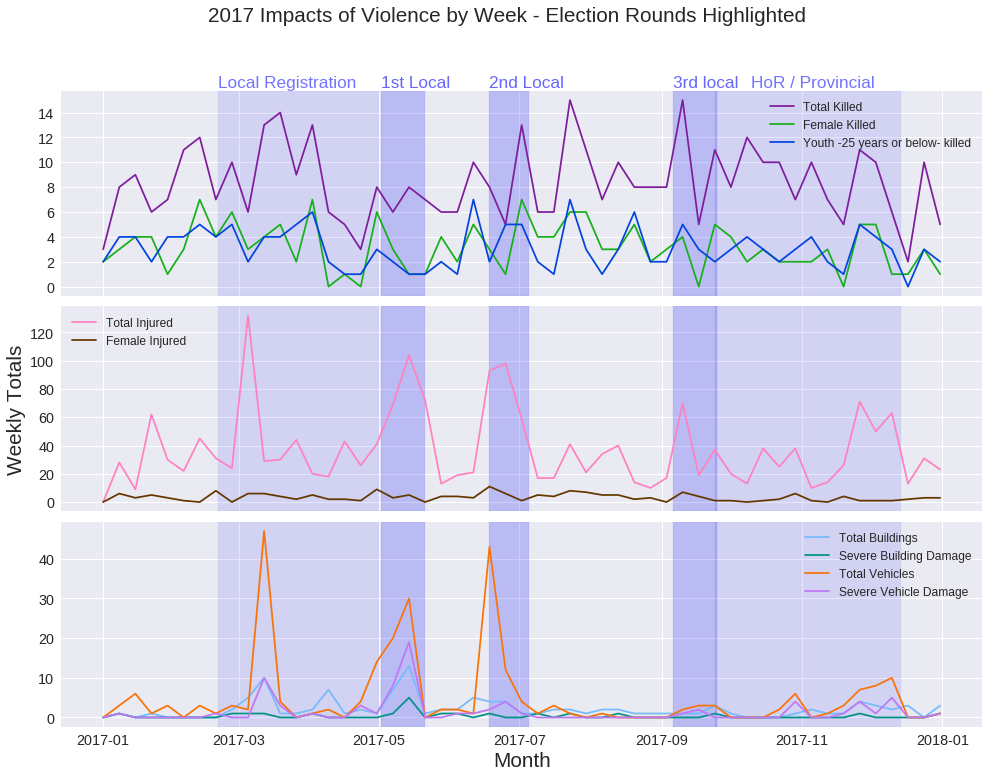

In [16]:
A3 = (16.5,11.7)
A4 = (11.7,8.3)
sns.set(font_scale=1)
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(3,1, sharex=True, figsize=A3)
fig.subplots_adjust(hspace=.05)
fig.suptitle('2017 Impacts of Violence by Week - Election Rounds Highlighted',fontsize='xx-large')

plt.axes(ax[0])
fullrun('Week', imweek,['Killed'],True)
plt.axes(ax[1])
fullrun('Week', imweek,['Injured'],False)
plt.ylabel('Weekly Totals', fontsize='xx-large')
plt.axes(ax[2])
fullrun('Week', imweek,['Physical'],False)
plt.xlabel('Month', fontsize='xx-large')
plt.xticks(fontsize='large')
for x in range(2):
    plt.setp(ax[x].get_xticklabels(), visible=False)

plt.show()

It is immediately apparent that, while there is no obvious correlation between election rounds and the total number of people killed or raped per week, there is a striking relationship between the total number of injured and the timing of the elections. Interestingly, the spikes in the total number of injured are not reflected in the number of 'Female Injured.' This can either be attributed to an exclusively male participation in election related contestation, or an inability to differentiate gender among injured in media reports. Reports of physical damage to buildings and vehicles similarly match the timing of election rounds


<a href='#top'>Back to top</a>
<a id='Question-2'></a>
## Question 2:
### Are impacts of violence correlated with population and/or with each other?

In [17]:
# Calculate overall homicide rate. 
tkilled = imdist_pop['Total Killed'].sum()
tpop = imdist_pop['Population'].sum()
hrate = round(tkilled/(tpop/100000),2)
print(' Total Killed:', int(tkilled),'\n'\
      ,'Population:',int(tpop),'\n'\
      , 'Homicide Rate Per 100,000:', hrate)

 Total Killed: 442 
 Population: 26252883 
 Homicide Rate Per 100,000: 1.68


Simply dividing the sum of the Total Killed by the sum of the population per district (divided by 100,000) yields a homicide rate of about 1.68 per 100,000 people. This can be used as a sanity check for subsequent figures.


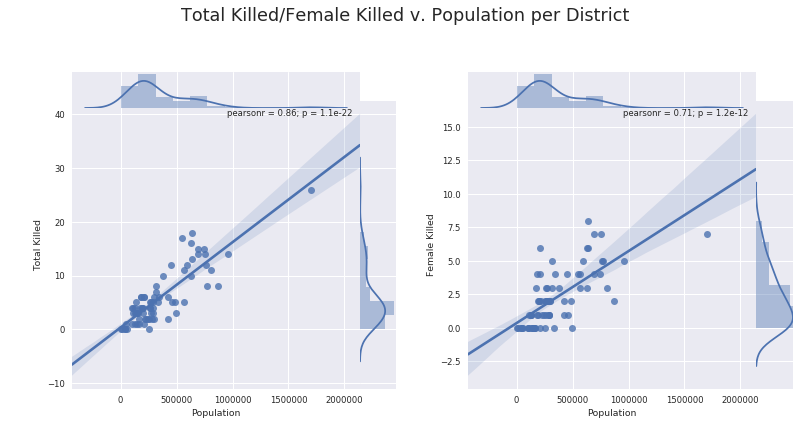

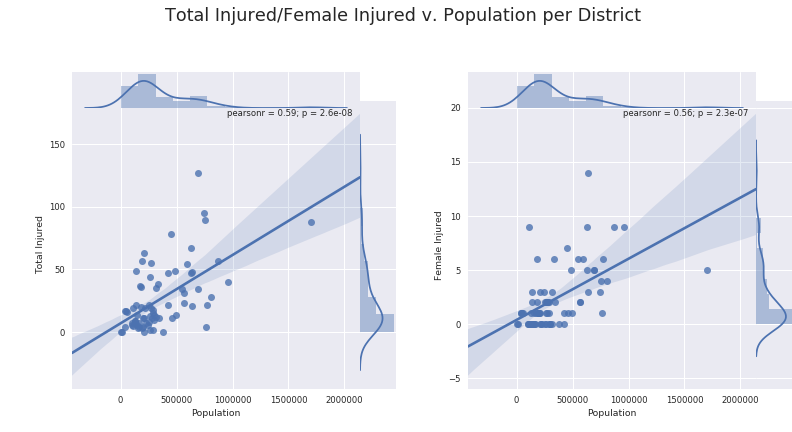

In [18]:
#plot two joint plots
yl = ['Total Killed', 'Female Killed',\
      'Total Injured', 'Female Injured']

#we plot2joints before we plot2joints
plot2joints(yl[0],yl[1])
#and then we plot two more. 
plot2joints(yl[2],yl[3])

From the joint plots above, there is an obvious relationship between district population and various impact numbers. For the Total Killed by population chart, for instance, a "pearsonr = 0.86" shows there is a essentially an 86% linear correlation between Population and 'Total Killed.' In the same graph, "p=1.1e-22" means there is a vanishingly small (1.1 * 10 to the negative 22nd) chance that the null hypothesis (that the relationship is a result of random chance) is correct.

Next we can create an entire data frame of impacts divided by corresponding district population numbers.

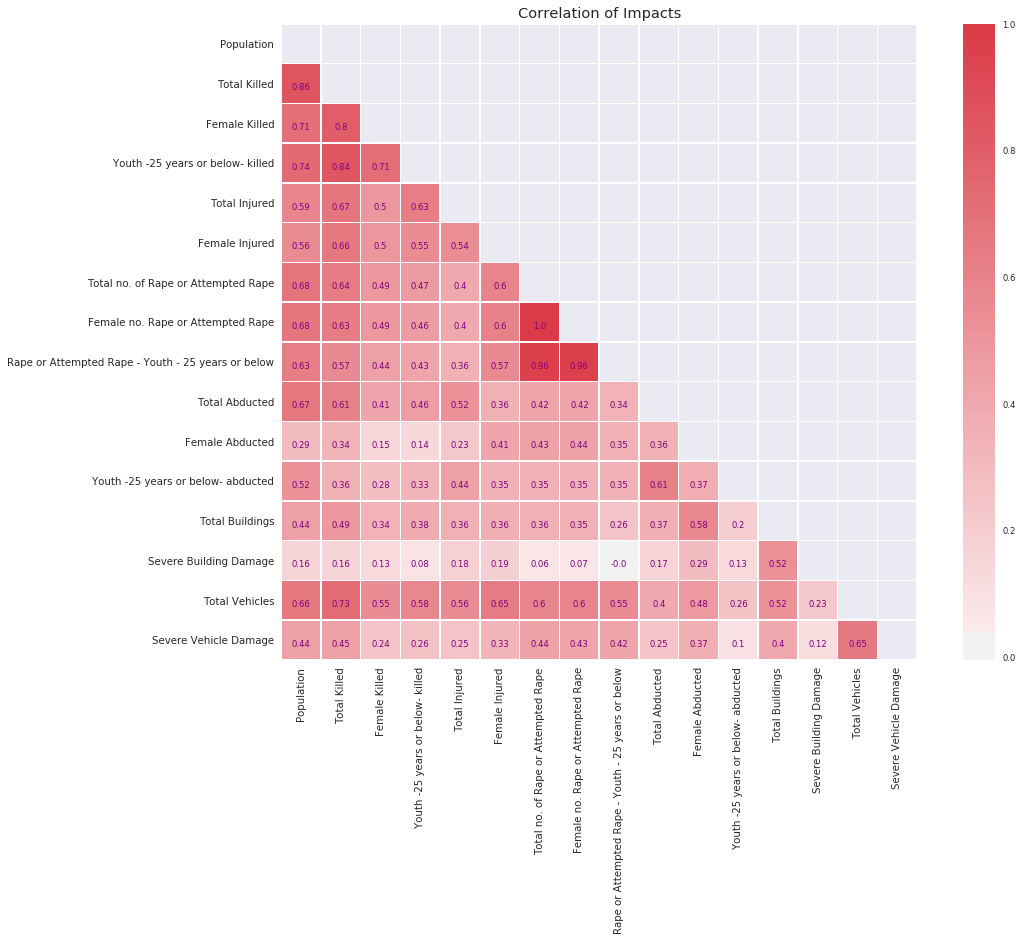

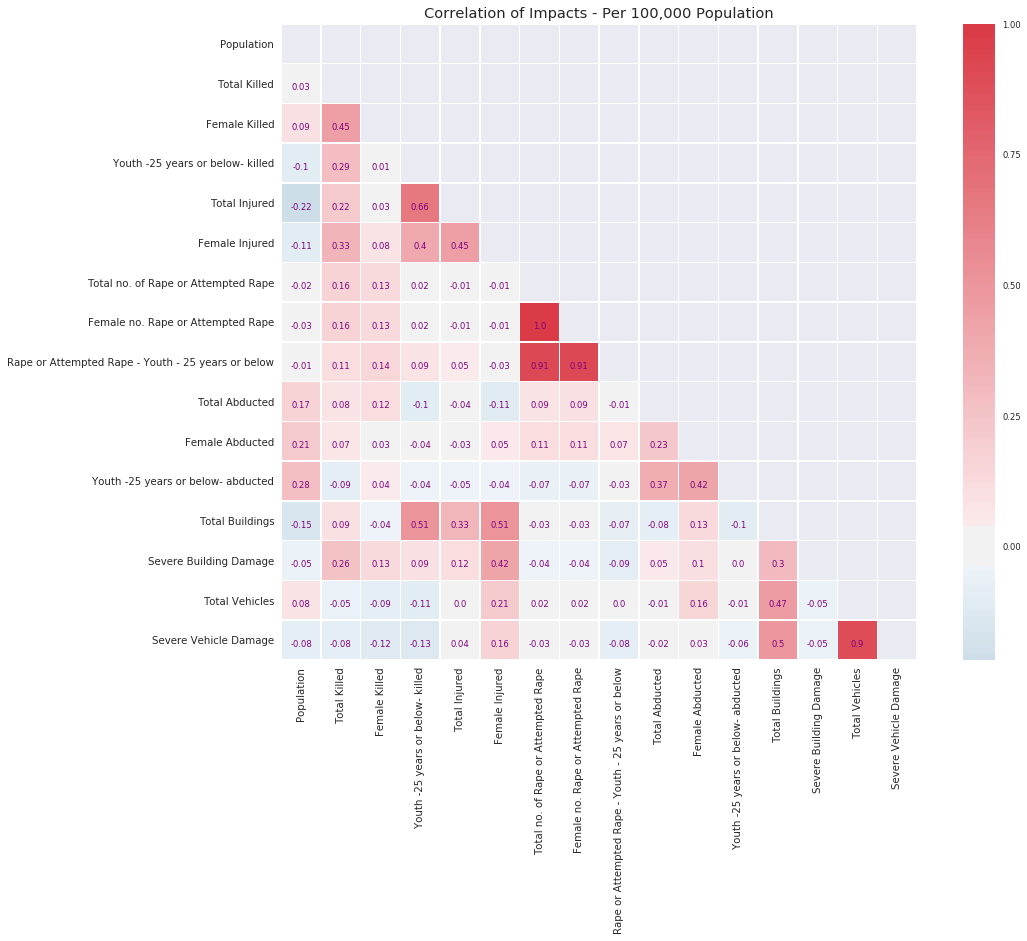

In [19]:
#plot heat maps
imdist_pop_no_prov = imdist_pop.drop('Province', axis=1)
plotheat(imdist_pop_no_prov,'Correlation of Impacts')
plotheat(imdist_normalized, 'Correlation of Impacts - Per 100,000 Population')
plt.show()

A correlation heat map of all impacts shows a slight correlation between nearly all impacts, save for severe building damage. This could be a function of all these impacts being correlated with population. The highest overall correlation with population appears to be "Total Killed." 

Controlling for population by using impact numbers re-mapped per 100,000 population reveals a few interesting hot-spots. Some correlations between impacts are obvious, as they reflect overlapping events. For example, "Female Killed" is a subset of "Total Killed" so both should be correlated with each other. The same applies for "Total injured" v. "Female Injured," "Total no. Rape or Attempted Rape" v. female and youth rape, etc. Total killed numbers still show slight correlations with most other impacts, even when controlling for population, including injuries, rapes, abductions, and building damage. This may be a result of multiple impacts resulting from the same major events, but perhaps also shows there are some commonalities beyond population numbers which might predict where violence takes place. Incorporating other demographic information could be informative.

Other interesting correlations in the population normalized heat map: 
- Total/Female Injured and Total Buildings damaged (pearsonr = 0.51).
- Total Buildings and Total Vehicles (pearsonr = 0.47) 
- Population and abductions (pearsonr = 0.17 - 0.28 despite normalization)
- Negative correlation between population and injuries per capita (pearsonr = -0.22)
- Higher correlation between Total Injured and Youth - below 25 - Killed (0.66) than Female Killed and Total Killed (0.45)


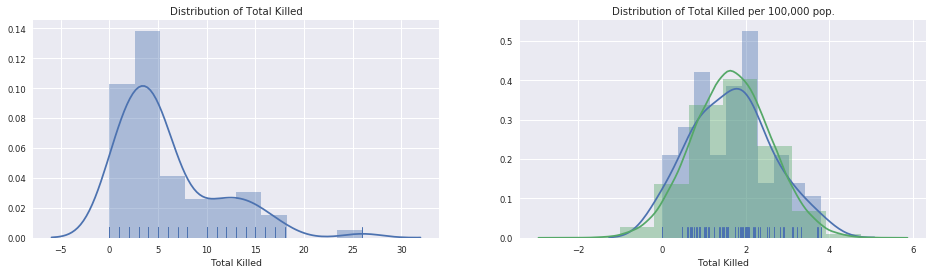

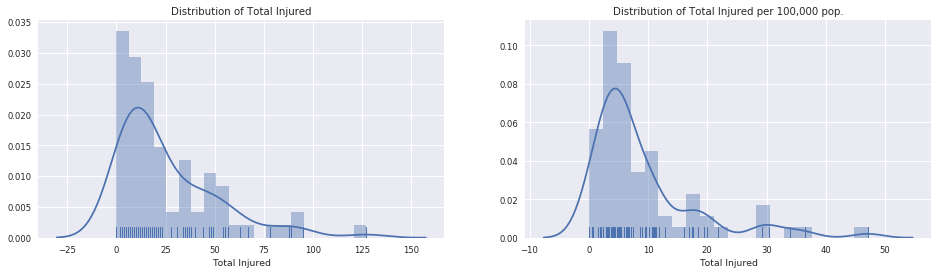

In [20]:
#Create histograms of impacts v impacts per 100,000 pop
f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.set_title('Distribution of Total Killed')
ax2.set_title('Distribution of Total Killed per 100,000 pop.')
sns.distplot(imdist_pop['Total Killed'], bins=10, rug=True, ax=ax1)
sns.distplot(imdist_normalized['Total Killed'], bins=10, rug=True, ax=ax2)

#overlay theoretical normal distrobution
sig1 = np.mean(imdist_normalized['Total Killed'])
tau1 = np.std(imdist_normalized['Total Killed'])
theo_killed_n = np.random.normal(sig1, tau1, size=100000)
sns.distplot(theo_killed_n, bins=10, ax=ax2)




sns.despine()
plt.show()

f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.set_title('Distribution of Total Injured')
ax2.set_title('Distribution of Total Injured per 100,000 pop.')
sns.distplot(imdist_pop['Total Injured'], bins=20, rug=True, ax=ax1)
sns.distplot(imdist_normalized['Total Injured'], bins=20, rug=True, ax=ax2)

sns.despine()
plt.show()




The effect of controlling for district population can be seen above.  The histograms in the left show the raw distribution of 'Total Killed' and 'Total Injured, with their similar skew to the right, indicating more districts have lower impact numbers and fewer districts have higher impact numbers. 

The histograms on the right show the same impacts per 100,000 population. While 'normalizing' the 'Total Killed' by population creates a more normal (bell shaped) distribution, doing the same to 'Total Injured,' barely changes the shape of the distribution at all. A theoretical normal distribution has been overlaid the Total Killed per 100,000 to show the similarity. 

More complex attempts at normalizing the 'Total Injured' numbers remain to be explored.

In [21]:
#Try normality test + total killed
from scipy import stats

#Shapiro-Wilk Normality test
wilkstat, wilkp = stats.shapiro(imdist_normalized['Total Killed'])
print('Shapiro-Wilk Test Results:')
print('Total Killed per 100,000 - Test Statistic:',round(wilkstat,5),' p-value:',round(wilkp,2))

Shapiro-Wilk Test Results:
Total Killed per 100,000 - Test Statistic: 0.97695  p-value: 0.19


A Shapiro-wilk test with a p-value of 0.19 means the distribution is probably normal or - more accurately - is not rejected as a normal distribution.

In [22]:
#import old population by ward datada
popfile = 'Data/nepal_population_household_ward-2011.csv'
pop_oldward = pd.read_csv(popfile)
pop_oldward.head()
pop_oldward.head()

,DISTRICT,V.D.C./MUNICIPALITY,dv_join,WARD NUMBER,HOUSEHOLD,POPULATION,CBS CODE,P_CODE_DIST,HLCIT_CODE_DIST,P_CODE_VDC,HLCIT_CODE_VDC,P_CODE_WARD,HLCIT_CODE_WARD,elevation_above_1500m
0,Achham,Babala,AchhamBabala,1,19,90,690001,F-SET-69,524 5 13 69,F-SET-69-001,524 5 13 69 5 008,F-SET-69-001-01,524 5 13 69 5 008 1,0
1,Achham,Babala,AchhamBabala,2,90,457,690001,F-SET-69,524 5 13 69,F-SET-69-001,524 5 13 69 5 008,F-SET-69-001-02,524 5 13 69 5 008 2,0
2,Achham,Babala,AchhamBabala,3,111,596,690001,F-SET-69,524 5 13 69,F-SET-69-001,524 5 13 69 5 008,F-SET-69-001-03,524 5 13 69 5 008 3,0
3,Achham,Babala,AchhamBabala,4,87,471,690001,F-SET-69,524 5 13 69,F-SET-69-001,524 5 13 69 5 008,F-SET-69-001-04,524 5 13 69 5 008 4,0
4,Achham,Babala,AchhamBabala,5,31,161,690001,F-SET-69,524 5 13 69,F-SET-69-001,524 5 13 69 5 008,F-SET-69-001-05,524 5 13 69 5 008 5,0


In [23]:
#agrigate population by old VDCS
oldVDC = pop_oldward.groupby(['HLCIT_CODE_VDC']).sum()
pop_oldVDC = oldVDC['POPULATION']
print(pop_oldVDC.shape)
pop_oldVDC.head()

(3973,)


HLCIT_CODE_VDC
524 1 01 01 5 001    14974
524 1 01 01 5 002     3605
524 1 01 01 5 003     2413
524 1 01 01 5 004     2214
524 1 01 01 5 005     4111
Name: POPULATION, dtype: int64

In [24]:
VDC_count = pop_oldward.groupby(['HLCIT_CODE_DIST']).nunique()
VDC_count['HLCIT_CODE_VDC'].mean()

52.973333333333336

In [25]:
#Create df of incidents by VDC
codes = df['HLCIT CODE'] 
shortcodes = codes.apply(lambda x: x[:17])
incidents_VDC = df
incidents_VDC['HLCIT CODE'] = shortcodes
incidents_VDC = incidents_VDC.groupby(['HLCIT CODE']).sum()
incidents_VDC = incidents_VDC.dropna(axis=1)
incidents_VDC = incidents_VDC.drop(['INCIDENT NUMBER','LATITUDE','LONGITUDE','VERIFIED'],axis=1)

#Join the incidents to population by VDC

pop_incidents_VDC = pop_oldVDC.to_frame()
pop_incidents_VDC = pop_incidents_VDC.join(incidents_VDC)

#pop_deaths_VDC['Deaths'] = Deaths
#pop_deaths_VDC = pop_deaths_VDC[0:-1]

#pop_deaths_VDC.shape
pop_incidents_VDC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3973 entries, 524 1 01 01 5 001 to 524 5 14 75 5 041
Data columns (total 13 columns):
POPULATION                                            3973 non-null int64
Total Killed                                          1302 non-null float64
Female Killed                                         1302 non-null float64
Total no. of Rape or Attempted Rape                   1302 non-null float64
Female no. Rape or Attempted Rape                     1302 non-null float64
Rape or Attempted Rape - Youth - 25 years or below    1302 non-null float64
Total Abducted                                        1302 non-null float64
Female Abducted                                       1302 non-null float64
Youth -25 years or below- abducted                    1302 non-null float64
Total Buildings                                       1302 non-null float64
Severe Building Damage                                1302 non-null float64
Total Vehicles                     

In [26]:
#(pop_incidents_VDC['Total Killed'].sum()/pop_incidents_VDC.POPULATION.sum())*100000
pop_incidents_VDC.POPULATION.sum()

26253639

In [27]:
3972/75

52.96

In [32]:
#Try normality test + total killed
from scipy import stats

#boot strap confidence interval for mean
#create bootstrap function

def bsVDC_all(size=390):
        VDCs = np.random.choice(pop_incidents_VDC.index, size=size)
        lst = pop_incidents_VDC.loc[VDCs].sum()
        return lst
    

def bsVDC_by_no(variable,size=390):
        VDCs = np.random.choice(pop_incidents_VDC.index, size=size)
        lst = pop_incidents_VDC.loc[VDCs]
        pop = lst['POPULATION'].sum()
        variable = lst[variable].sum()
        bs_VDCs = [variable,pop]
        return bs_VDCs

def bsVDC_by_pop(variable,size=2000000):
        pop = 0
        out = 0
        VDCs = np.random.choice(pop_incidents_VDC.index, size=500)
        #while pop < size:
         #   np.append(VDCs, np.random.choice(pop_incidents_VDC.index, size=1))
        lst = pop_incidents_VDC.loc[VDCs]
        pop = lst['POPULATION'].sum()
        #print(pop)
        while pop > size:
            reduce = 1 + int((pop - size) / 100000)
            lst = lst[0:-reduce]
            pop = lst['POPULATION'].sum()
            #print(pop,reduce)
        out = lst[variable].sum()                
        bs_VDCs = [out,pop]
        return bs_VDCs

#call bootstrap function for mean

bs_VDCs = pd.DataFrame()
for i in range(10000):
    variable = 'Total Killed'
    lst = bsVDC_all()
    bs_VDCs[i] = lst
    #print(i)
bs_VDCs = bs_VDCs.transpose()
bs_VDCs
#cltmean = np.mean(bs_VDCs)
#print('\nSample mean:',round(cltmean,2))

#find 95% confidence interval for mean
#conf95 = np.percentile(bs_VDCs, [2.5,97.5])

#print('\n95% confidence interval:',round(conf95[0],2),round(conf95[1],2))

#f, ax = plt.subplots(figsize=(11,8.5))
#sns.distplot(bs_VDCs, label='distribution of deaths per capita')
#ax.axvspan(conf95[0],conf95[1], alpha=.5, label='95% confidence interval')
#ax.axvline(cltmean, color='r',label='sample mean')
#plt.title(variable+' per 100,000 people - 390 VDCs 100,000 samples')
#plt.xlabel('Total Killed per 100,000 people')
#plt.ylabel('Density of values')
#plt.legend()
#plt.show()


,POPULATION,Total Killed,Female Killed,Total no. of Rape or Attempted Rape,Female no. Rape or Attempted Rape,Rape or Attempted Rape - Youth - 25 years or below,Total Abducted,Female Abducted,Youth -25 years or below- abducted,Total Buildings,Severe Building Damage,Total Vehicles,Severe Vehicle Damage
0,2204978.0,35.0,14.0,31.0,31.0,25.0,1.0,0.0,1.0,6.0,1.0,19.0,5.0
1,2407029.0,39.0,17.0,36.0,36.0,30.0,5.0,1.0,1.0,10.0,1.0,13.0,9.0
2,2259309.0,27.0,9.0,27.0,27.0,25.0,8.0,0.0,4.0,9.0,3.0,25.0,5.0
3,2234135.0,24.0,9.0,24.0,24.0,18.0,1.0,0.0,0.0,2.0,0.0,16.0,8.0
4,2189043.0,24.0,9.0,29.0,29.0,23.0,3.0,9.0,1.0,7.0,0.0,22.0,10.0
5,2236176.0,32.0,11.0,20.0,17.0,18.0,4.0,1.0,1.0,6.0,0.0,31.0,9.0
6,2560424.0,53.0,20.0,43.0,41.0,33.0,4.0,1.0,1.0,11.0,1.0,39.0,13.0
7,2442874.0,42.0,17.0,46.0,46.0,37.0,2.0,9.0,2.0,8.0,2.0,19.0,7.0
8,2566766.0,37.0,12.0,29.0,28.0,25.0,4.0,2.0,1.0,13.0,2.0,44.0,9.0
9,2491109.0,35.0,17.0,44.0,44.0,34.0,6.0,2.0,4.0,1.0,0.0,27.0,7.0


After establishing that the distribution of total killed per 100,000 people is approximately normal, A confidence interval can establish "what is abnormal," as well as where the 'actual' value is likely to be regardless of sampling error. This cannot be done effectively with a by-district sample, because with 75 districts it is impossible to draw a sample that is both less than 10% of the dataset and the over the threshold needed for the central limit theorem to apply.  To account for this, we can divide our dataset into the next geographical unit down, the "Village Development Committee" (VDC). We can then draw 390 VDC's from the dataset (just under 10%), divide the total reported deaths by it's population, and do this 10,000 times. This should hopefully account for much of the random variation of reports being missed or included in the dataset.


95% of the simulations result in a value between 1.06, and 2.27 'Total Killed' per 100,000 people. The methodology is not based on a random sample of the population, but on a comprehensive effort to map all media reports. So, we can interpret this result to mean that in 2017 violent deaths in Nepal were reported by the media at a rate between 1.06 and 2.27 deaths per 100,000 people with 95% confidence.



<a href='#top'>Back to top</a>
<a id='Question-3'></a>
## Question 3:
### Are there significant differences in trends between provinces that can be shown?

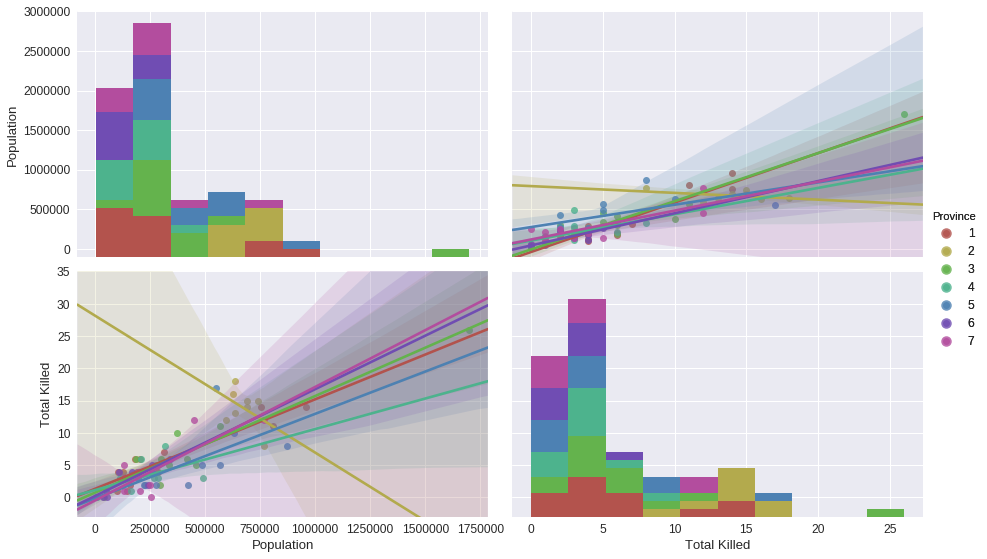

In [29]:
#try pairplot for the df

#create a custom palete for provices, so they don't loop around past 6. - use consistently from here out.
provpal = sns.hls_palette(7, l=.5, s=.4)

sns.set(font_scale=1.2)
plt.style.use('seaborn-darkgrid')
pg = sns.pairplot(imdist_pop, kind='reg', hue='Province', vars=['Population','Total Killed'],size=4, aspect=1.5, palette=provpal)
#turn off the labels in the middle - increase data/ink ratio
pg.add_legend(markerscale=1.5)
pg.axes[0][0].set_ylim([-100000,3000000])
pg.axes[1][0].set_ylim([-3,35])
plt.setp(pg.axes[0][0].get_xticklabels(), visible=False)
plt.setp(pg.axes[0][1].get_xticklabels(), visible=False)
plt.setp(pg.axes[0][1].get_yticklabels(), visible=False)
plt.setp(pg.axes[1][1].get_yticklabels(), visible=False)
#adjust space between plots
plt.subplots_adjust(hspace=.06, wspace=0.06)

sns.despine()
plt.show()

Shading a pair plot of Total Killed v. Population per district according to province, produces a histogram of population per district and Total Killed by district, while combining both together in scatter plots. It is immediately apparent that both the histograms look very much like each other. The most common number of people per district is around 250,000 while the most common Total Killed is somewhere between 2.5 and 5, with the distribution rapidly falling off in both graphs as numbers rise.

Kathmandu district can be seen standing apart in all graphs with a population of slightly under 1,750,000 and approximately 26 Total Killed, colored to match province 3. Province 2 also stands out, in that it doesn't have any districts with a population below 500,000, and is thus responsible for a "bulge" in the middle of both histograms. 

Of course, the most obvious way in which Province 2 stands out is with its regression line. All other provinces more or less display a regression line correlating Total Killed with Population, while Province 2, displays a prominently different trend. Why is this?

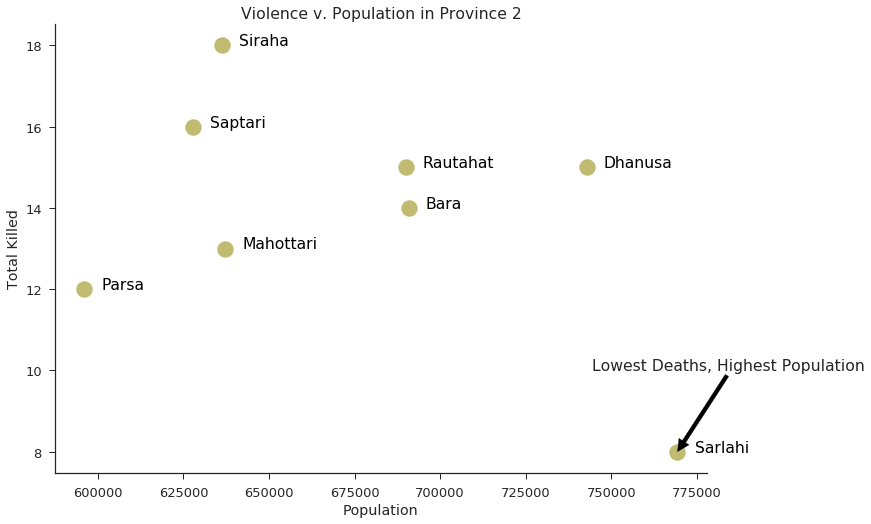

In [30]:
#Province 2 looks like an outlier for total killed in political violence. Let's plot it
im_province2 = imdist_pop.loc[imdist_pop['Province'] == 2].reset_index()
sns.set(font_scale=1.3)
#sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots()
ax.set_title("Violence v. Population in Province 2")
fig.set_size_inches(11.69, 8.25)
p1 = sns.regplot(x="Population", y="Total Killed", data=im_province2, fit_reg=False, scatter_kws={"s": 270}, color=provpal[1])

#label districts
for row in range(0,im_province2.shape[0]):
    ycorrect = 0
    #if im_province2.District[row] == 'Bara':
        #ycorrect = 0.5
    p1.text(im_province2.Population[row]+5000, im_province2['Total Killed'][row]-ycorrect, im_province2.District[row], horizontalalignment='left', size='medium', color='black')

sns.despine()#take off the top borders

#annotate with arrow
yloc=im_province2['Total Killed'].loc[im_province2.District == 'Sarlahi']
xloc=im_province2['Population'].loc[im_province2.District == 'Sarlahi']
plt.annotate('Lowest Deaths, Highest Population', xy=(xloc,yloc), xytext=(xloc-25000,yloc+2) ,arrowprops=dict(facecolor='black'))
plt.show()

Zooming in to plot province 2 alone, it is clear that Sarlahi has seen the lowest Total Killed in 2017 while possessing the highest population. But, is the 2nd Province's bucking the trend a result of unusually low deaths in Sarlahi, or unusually high deaths in the other districts?

Total P-value 1.14917306785e-22
Province 2 - P-value: 0.292518511059


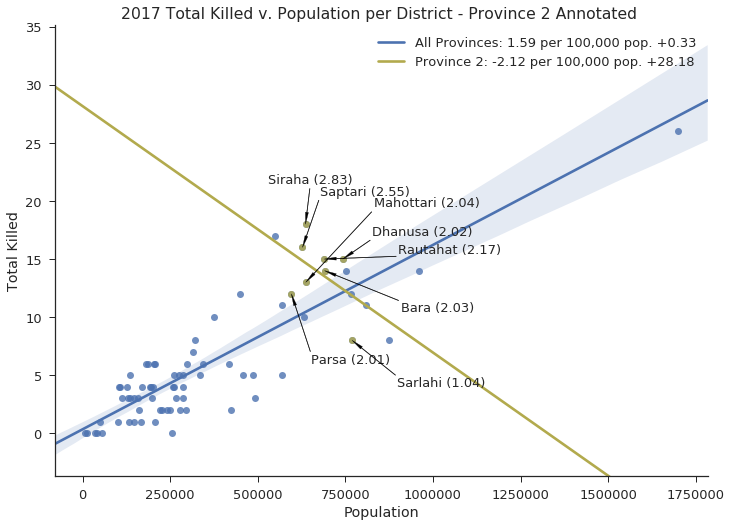

In [31]:
from scipy import stats

#create frame for just province 2
imdist_prov2 = imdist_pop.loc[imdist_pop.Province == 2]

#Plot population v totals deaths regression line and devation of province 2 districts from trend. 
fig, ax = plt.subplots()
fig.set_size_inches(A4)
plt.title ('2017 Total Killed v. Population per District - Province 2 Annotated ')

# get coeffs of linear fit for legend. 
slope, intercept, r_value, p_value, std_err = stats.linregress(imdist_pop['Population'], imdist_pop['Total Killed'])
slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(imdist_prov2['Population'], imdist_prov2['Total Killed'])

sns.set_style('white')
p3 = sns.regplot(x='Population', y='Total Killed', data=imdist_pop,\
    line_kws={'label':"All Provinces: {0:.2f} per 100,000 pop. +{1:.2f}".format(slope*100000,intercept)})
ylim = p3.get_ylim()

#Plot anotother regression line over the same graph
p3 = sns.regplot(x='Population', y='Total Killed', data=imdist_prov2,\
    color=provpal[1], fit_reg=True, truncate=False, ci=None,\
    line_kws={'label':"Province 2: {0:.2f} per 100,000 pop. +{1:.2f}".format(slope2*100000,intercept2)})
p3.set_ylim(ylim)

#poplulate poslist with the dots
poslist = [tuple([-1,-1])]
for row in imdist_pop.index:
    x = imdist_pop.Population[row]
    y = imdist_pop['Total Killed'][row]
    poslist.append(tuple([x,y]))
#print(poslist)

districts = {}    
for row in range(0,imdist_pop.shape[0]):
    if imdist_pop.Province[row] == 2:
        text = imdist_pop.index[row]
        ypos = imdist_pop['Total Killed'][row]
        xpos = imdist_pop['Population'][row]
        districts[text] = [xpos,ypos,xpos,ypos]
label_districts(poslist,districts)

sns.despine()#take off the top borders

# plot legend
ax.legend()
print('Total P-value', p_value)
print('Province 2 - P-value:', p_value2)
#show it
plt.show()

By plotting the overall Total Killed v. Population, We can see the reason for Province 2 bucking the trend is two fold: Sarlahi has far fewer violent deaths per-capita than the linear regression line for all provinces(1.59 +0.33 deaths per 100,000 people), while Parsa, Saptari, Siraha, and Rautahat have considerably more. These are different enough from each other to result in a regression line of (-2.12 +28.3 deaths per 100,000 people) for province 2. 

Note that 1.59 +0.33 deaths per 100,000 people passes the sanity check (1.68 per 100,000 homicide rate) from Question 2 and is even closer to the mean of 1.63 deaths per 100,000 people resulting from the subsequent 95% confidence interval. 


In [32]:
#put the Provinces back in imdist normalized
prov_only = pop_pd.drop('Population', axis=1)
imdist_pop_normalized = prov_only.join(imdist_normalized)
imdist_pop_normalized = imdist_pop_normalized.drop('Population', axis=1)
#imdist_pop_normalized.head()

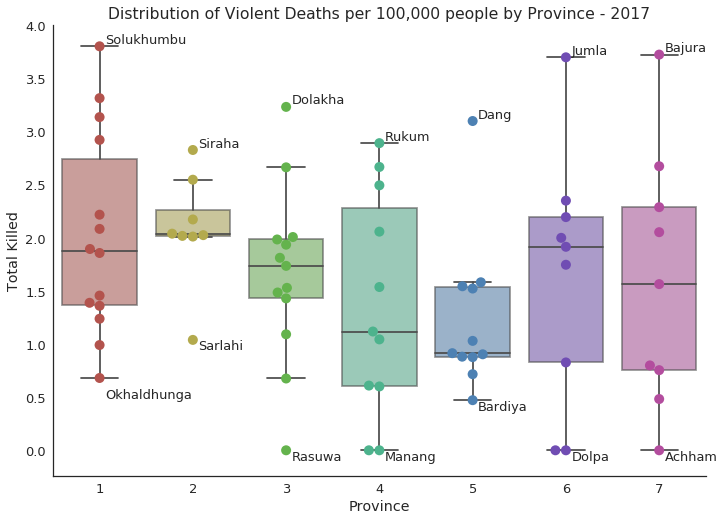

In [33]:
boxswarm(imdist_pop_normalized,'Total Killed','Violent Deaths per 100,000 people')

The the box plot above visualizes the distribution of violent deaths per 100,000 people over Nepal's federal provinces.  Each dot in the overlaid swarm plot represents a district, with it's vertical position indicating the 'Total Killed' per 100,000 pop. in that district. Each province is plotted separately, by the province number, with the leading and trailing districts for each labeled. 

The outlier status of Sarlahi can be seen in province 2, with ~1.1 killed per 100,000 people, while the rest of the Province is bunched up between 2 and 3 killed per 100,000, with a median of ~2.1 per 100,000. Note that despite the wide distribution between 0 and 4 Killed per 100,000, the boxes are mostly centered along the 1.59 deaths per 100,000 line from the previous regression plot, with the medians between 1 and 2.1 deaths per 100,000 people.



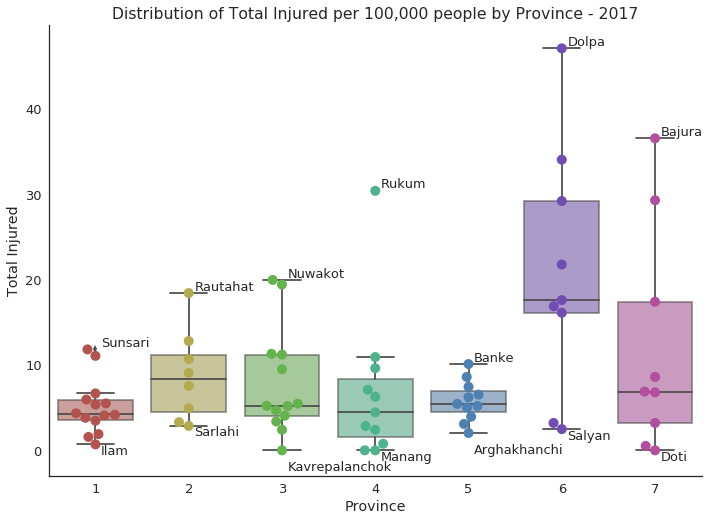

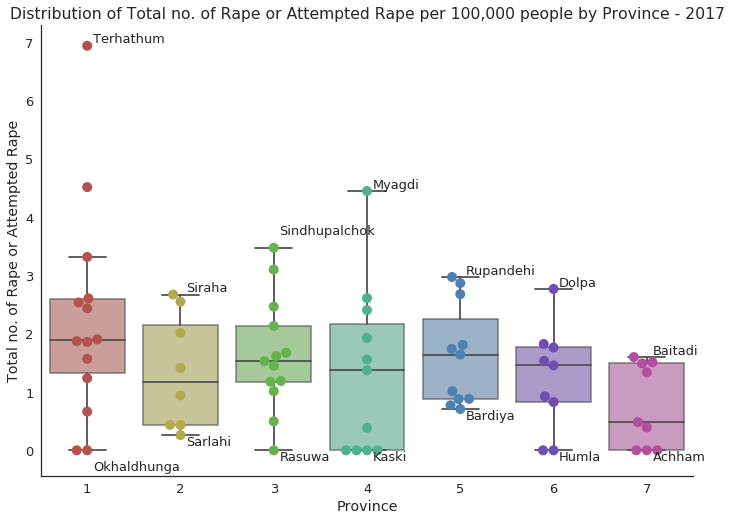

In [34]:
impactlist = ['Total Injured', 'Total no. of Rape or Attempted Rape']
for impact in impactlist:
    boxswarm(imdist_pop_normalized,impact,impact+' per 100,000 people')


Extending this approach to other impacts reveals that province 6 has a much wider distribution of injured per 100,000 people than others, with higher relative numbers. The same applies for Province 1 in no. of Rape or Attempted Rape per 100,000 people. Note: many low population districts have fewer than 100,000 people.

<a href='#top'>Back to top</a>
<a id='Conclusions'></a>
## Conclusions:


### The impacts of violence in the Nepal Monitor are correlated with events.

Specifically, injuries and physical damage appear correlated with electoral rounds, while other impacts have no obvious correlation with events. 

### These impacts are also correlated with population and with each other in various ways.

'Total Killed' is the most highly correlated with population, but all other impacts are at least somewhat correlated with population, and therefore with each other.  When controlling for population numbers, there are still a few relationships left between impacts, most likely based on where electoral violence took place, such as a surprisingly high correlation between female injuries and building damage. Additionally, there is a slight correlation between district population and Female Abduction per 100,000 people, indicating there may be a relationship with sexual trafficking and population density.

### There are significant differences in trends between provinces.

While some trends disappear when controlling for population, others reveal themselves, particularly in lower population provinces. As the Total Killed per capita does not seem to be significantly correlated with protest events, it may be worth investigating why Sarlahi has so few deaths per capita compared to the rest of it's province, in addition to being the lowest in province 2 for rapes and injuries.

## Remaining Questions:

- How would other demographics besides population correlate with impacts and incident numbers?
- What factors could be used to normalize the distribution of other Impacts?
- What would a time series by province reveal?
- Is media coverage a factor?
- Would aggregating data by smaller geographical units create more meaningful statistical relationships?
- Can the 'Causes of Violence' category be predicted, or used to control for other factors. 
- What hypothesis might be useful to test using machine learning techniques? 


